In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
import prep
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

wrangle.py functions loaded successfully
acquire.py functions loaded successfully


# 

In [2]:
df = prep.prep_zillow_data()
df.isna().sum()
df.fullbathcnt.head()

0    3.0
1    2.0
2    1.0
3    3.0
4    2.0
Name: fullbathcnt, dtype: float64

In [3]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test(df)

In [4]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scale(X_train, X_validate, X_test)

In [5]:
X_train_scaled

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
9313,0.25,0.166667,0.166667,0.173552,0.111111
1308,0.20,0.250000,0.111111,0.256174,0.111111
11475,0.20,0.333333,0.111111,0.358643,0.111111
16038,0.30,0.250000,0.222222,0.376875,0.222222
1198,0.10,0.083333,0.000000,0.156935,0.000000
...,...,...,...,...,...
2465,0.30,0.333333,0.222222,0.520194,0.222222
6773,0.20,0.166667,0.111111,0.150012,0.111111
5750,0.20,0.250000,0.111111,0.304408,0.111111
17625,0.30,0.333333,0.222222,0.538195,0.222222


In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

In [7]:
f_selector = SelectKBest(f_regression, k=5)

In [8]:
f_selector = f_selector.fit(X_train_scaled, y_train.taxvaluedollarcnt)

In [9]:
X_train_reduced = f_selector.transform(X_train_scaled)
print(X_train.shape)
print(X_train_reduced.shape)

(11746, 5)
(11746, 5)


In [10]:
f_support = f_selector.get_support()
f_support

array([ True,  True,  True,  True,  True])

In [11]:
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt']

In [12]:
X_reduced_scaled = X_train_scaled.iloc[:, f_support]
X_reduced_scaled.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
9313,0.25,0.166667,0.166667,0.173552,0.111111
1308,0.20,0.250000,0.111111,0.256174,0.111111
11475,0.20,0.333333,0.111111,0.358643,0.111111
16038,0.30,0.250000,0.222222,0.376875,0.222222
1198,0.10,0.083333,0.000000,0.156935,0.000000


In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [14]:
lm = LinearRegression()

rfe = RFE(lm, 5)

lm_X_rfe = rfe.fit_transform(X_train,y_train) 

In [15]:
mask = rfe.support_ 
rfe_features = X_train.columns[mask]
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fullbathcnt


In [16]:
lm.fit(lm_X_rfe, y_train)

LinearRegression()

In [17]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression()
intercept:  [44807.1713353]
features:  Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt'],
      dtype='object')
coefficients:  [[ 129714.6420099  -108982.63989217  -26781.71316692     339.57650261
   -31021.79859825]]


In [18]:
y_train['yhat_lm'] = lm.predict(lm_X_rfe)

y_train.head()

,taxvaluedollarcnt,yhat_lm
9313,222641.0,379365.097212
1308,261391.0,340484.380834
11475,427992.0,382273.708102
16038,176043.0,589994.021946
1198,503743.0,340520.634249


In [19]:
RMSE_lm = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_lm))
RMSE_lm

387621.87590380665

In [20]:
r2_lm = lm.score(lm_X_rfe, y_train.taxvaluedollarcnt)

r2_lm

0.29686157496714216

In [21]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = 4.481e+04 + 1.3e+05 * bathroomcnt + -1.09e+05 * bedroomcnt'

In [22]:
lm_X_rfe = rfe.fit_transform(X_validate,y_validate)
mask = rfe.support_ 
rfe_features = X_validate.columns[mask]
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fullbathcnt


In [23]:
y_validate['yhat_lm'] = lm.predict(lm_X_rfe).round(1)

y_validate.head()

,taxvaluedollarcnt,yhat_lm
7557,294232.0,170096.1
111,203113.0,570356.3
7759,592933.0,236595.4
10968,785799.0,1078459.2
14557,381637.0,286152.1


In [24]:
RMSE_lm = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_lm))
RMSE_lm

396767.3522806633

In [25]:
r2_lm = lm.score(lm_X_rfe, y_validate.taxvaluedollarcnt)

r2_lm

0.28081357670979523

In [26]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = 4.481e+04 + 1.3e+05 * bathroomcnt + -1.09e+05 * bedroomcnt'

462262.2248865707
-2.220446049250313e-16


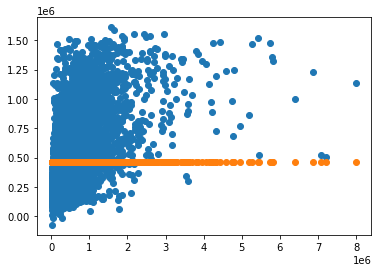

In [27]:
y_train['yhat_baseline'] = df['taxvaluedollarcnt'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_baseline))
print(RMSE_bl)

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.yhat_baseline)
print(evs)
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly_X_rfe = rfe.fit_transform(X_train,y_train)

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(poly_X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x4^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x3^2',
 'x1 x3 x4',
 'x1 x4^2',
 'x2^3',
 'x2^2 x3',
 'x2^2 x4',
 'x2 x3^2',
 'x2 x3 x4',
 'x2 x4^2',
 'x3^3',
 'x3^2 x4',
 'x3 x4^2',
 'x4^3',
 'x0^4',
 'x0^3 x1',
 'x0^3 x2',
 'x0^3 x3',
 'x0^3 x4',
 'x0^2 x1^2',
 'x0^2 x1 x2',
 'x0^2 x1 x3',
 'x0^2 x1 x4',
 'x0^2 x2^2',
 'x0^2 x2 x3',
 'x0^2 x2 x4',
 'x0^2 x3^2',
 'x0^2 x3 x4',
 'x0^2 x4^2',
 'x0 x1^3',
 'x0 x1^2 x2',
 'x0 x1^2 x3',
 'x0 x1^2 x4',
 'x0 x1 x2^2',
 'x0 x1 x2 x3',
 'x0 x1 x2 x4',
 'x0 x1 x3^2',
 'x0 x1 x3 x4',
 'x0 x1 x4^2',
 'x0 x2^3',
 'x0 x2^2 x3',
 'x0 x2^2 x4',
 'x0

In [29]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_1'] = lm_poly.predict(X_poly)

In [30]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_1))
RMSE_poly

386753.4785654679

In [31]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1
9313,222641.0,379365.097212,467226.149259,336428.220108
1308,261391.0,340484.380834,467226.149259,367696.962514
11475,427992.0,382273.708102,467226.149259,428068.817825
16038,176043.0,589994.021946,467226.149259,567505.674529
1198,503743.0,340520.634249,467226.149259,208487.975253


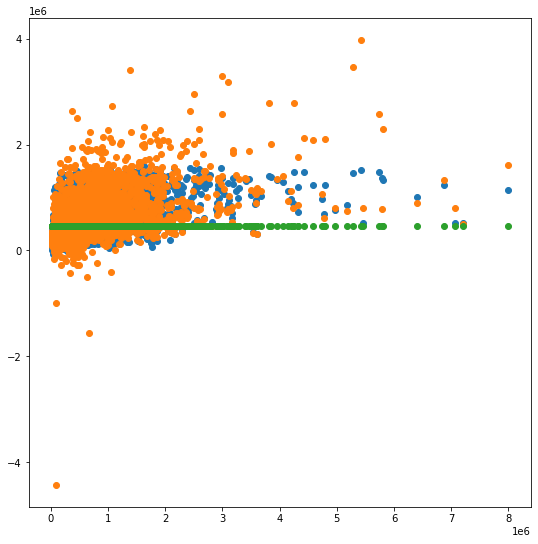

In [32]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_poly_1, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

In [33]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(poly_X_rfe)

In [34]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_2'] = lm_poly.predict(X_poly)

In [35]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_2))
RMSE_poly

378429.68233185686

In [36]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1,yhat_poly_2
9313,222641.0,379365.097212,467226.149259,336428.220108,303945.664603
1308,261391.0,340484.380834,467226.149259,367696.962514,333908.039083
11475,427992.0,382273.708102,467226.149259,428068.817825,370336.042247
16038,176043.0,589994.021946,467226.149259,567505.674529,578380.619043
1198,503743.0,340520.634249,467226.149259,208487.975253,313459.856424


In [37]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(poly_X_rfe)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_3'] = lm_poly.predict(X_poly)
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_3))
RMSE_poly

380409.4558204644

In [38]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1,yhat_poly_2,yhat_poly_3
9313,222641.0,379365.097212,467226.149259,336428.220108,303945.664603,304556.562718
1308,261391.0,340484.380834,467226.149259,367696.962514,333908.039083,335456.387157
11475,427992.0,382273.708102,467226.149259,428068.817825,370336.042247,382108.035361
16038,176043.0,589994.021946,467226.149259,567505.674529,578380.619043,560286.528744
1198,503743.0,340520.634249,467226.149259,208487.975253,313459.856424,306672.033139


In [59]:
y_train['base_perc_error'] = ((y_train.taxvaluedollarcnt - y_train.yhat_baseline) / y_train.taxvaluedollarcnt) * 100
y_train.base_perc_error.sum()

-1286457.5597519297

In [39]:
val_poly_X_rfe = rfe.fit_transform(X_validate,y_validate) 

In [40]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(val_poly_X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x4^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x3^2',
 'x1 x3 x4',
 'x1 x4^2',
 'x2^3',
 'x2^2 x3',
 'x2^2 x4',
 'x2 x3^2',
 'x2 x3 x4',
 'x2 x4^2',
 'x3^3',
 'x3^2 x4',
 'x3 x4^2',
 'x4^3',
 'x0^4',
 'x0^3 x1',
 'x0^3 x2',
 'x0^3 x3',
 'x0^3 x4',
 'x0^2 x1^2',
 'x0^2 x1 x2',
 'x0^2 x1 x3',
 'x0^2 x1 x4',
 'x0^2 x2^2',
 'x0^2 x2 x3',
 'x0^2 x2 x4',
 'x0^2 x3^2',
 'x0^2 x3 x4',
 'x0^2 x4^2',
 'x0 x1^3',
 'x0 x1^2 x2',
 'x0 x1^2 x3',
 'x0 x1^2 x4',
 'x0 x1 x2^2',
 'x0 x1 x2 x3',
 'x0 x1 x2 x4',
 'x0 x1 x3^2',
 'x0 x1 x3 x4',
 'x0 x1 x4^2',
 'x0 x2^3',
 'x0 x2^2 x3',
 'x0 x2^2 x4',
 'x0

In [41]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate.taxvaluedollarcnt)
y_validate['yhat_poly'] = lm_poly.predict(X_poly).round(1)

In [42]:
RMSE_poly = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_poly))
RMSE_poly

382637.3800996755

In [43]:
y_validate.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly
7557,294232.0,170096.1,284167.8
111,203113.0,570356.3,566428.2
7759,592933.0,236595.4,287559.1
10968,785799.0,1078459.2,1182784.4
14557,381637.0,286152.1,285552.2


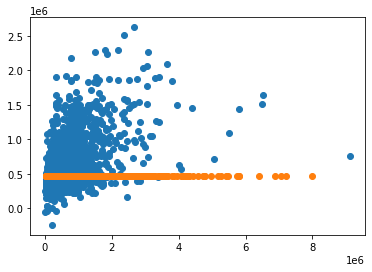

In [44]:
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_poly, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

In [45]:
test_poly_X_rfe = rfe.fit_transform(X_test,y_test) 

In [46]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(test_poly_X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x4^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x3^2',
 'x1 x3 x4',
 'x1 x4^2',
 'x2^3',
 'x2^2 x3',
 'x2^2 x4',
 'x2 x3^2',
 'x2 x3 x4',
 'x2 x4^2',
 'x3^3',
 'x3^2 x4',
 'x3 x4^2',
 'x4^3',
 'x0^4',
 'x0^3 x1',
 'x0^3 x2',
 'x0^3 x3',
 'x0^3 x4',
 'x0^2 x1^2',
 'x0^2 x1 x2',
 'x0^2 x1 x3',
 'x0^2 x1 x4',
 'x0^2 x2^2',
 'x0^2 x2 x3',
 'x0^2 x2 x4',
 'x0^2 x3^2',
 'x0^2 x3 x4',
 'x0^2 x4^2',
 'x0 x1^3',
 'x0 x1^2 x2',
 'x0 x1^2 x3',
 'x0 x1^2 x4',
 'x0 x1 x2^2',
 'x0 x1 x2 x3',
 'x0 x1 x2 x4',
 'x0 x1 x3^2',
 'x0 x1 x3 x4',
 'x0 x1 x4^2',
 'x0 x2^3',
 'x0 x2^2 x3',
 'x0 x2^2 x4',
 'x0

In [47]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_test.taxvaluedollarcnt)
y_test['yhat_poly'] = lm_poly.predict(X_poly).round(1)

In [48]:
RMSE_poly = np.sqrt(mean_squared_error(y_test.taxvaluedollarcnt, y_test.yhat_poly))
RMSE_poly

418205.3073422054

In [49]:
y_test.head()

,taxvaluedollarcnt,yhat_poly
16254,323000.0,311548.8
19572,489857.0,409372.9
1631,406174.0,351784.7
12252,96661.0,495246.2
2736,68910.0,302473.1


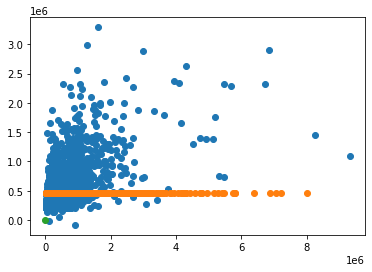

In [69]:
plt.scatter(y_test.taxvaluedollarcnt, y_test.yhat_poly, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')
plt.scatter(x = 1, y = 1)

In [57]:
y_test['perc_error'] = ((y_test.taxvaluedollarcnt - y_test.yhat_poly) / y_test.taxvaluedollarcnt) * 100
y_test

,taxvaluedollarcnt,yhat_poly,perc_error
16254,323000.0,311548.8,3.545263
19572,489857.0,409372.9,16.430121
1631,406174.0,351784.7,13.390640
12252,96661.0,495246.2,-412.353690
2736,68910.0,302473.1,-338.939341
...,...,...,...
5130,1076164.0,1117762.5,-3.865442
13785,332000.0,221345.2,33.329759
3405,408000.0,214797.1,47.353652
14824,572000.0,529881.7,7.363339


In [68]:
print('MVP error',(y_test.perc_error.sum()).round(2))
print('Baseline error:',(y_train.base_perc_error.sum()).round(2))
print('Our model had', (y_train.base_perc_error.sum() / y_test.perc_error.sum()).round(1), 'times less error than baseline')

MVP error -277759.98
Baseline error: -1286457.56
Our model had 4.6 times less error than baseline
